# _(Brette, et, al., 2007)_ COBA-HH

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95

In [1]:
import numpy as np
import brainpy as bp

bp.backend.set('numba', dt=0.03)

In [2]:
num_exc = 3200
num_inh = 800
Cm = 200  # Membrane Capacitance [pF]

gl = 10.  # Leak Conductance   [nS]
El = -60.  # Resting Potential [mV]
g_Na = 20. * 1000
ENa = 50.  # reversal potential (Sodium) [mV]
g_Kd = 6. * 1000  # K Conductance      [nS]
EK = -90.  # reversal potential (Potassium) [mV]
VT = -63.
Vt = -20.
# Time constants
taue = 5.  # Excitatory synaptic time constant [ms]
taui = 10.  # Inhibitory synaptic time constant [ms]
# Reversal potentials
Ee = 0.  # Excitatory reversal potential (mV)
Ei = -80.  # Inhibitory reversal potential (Potassium) [mV]
# excitatory synaptic weight
we = 6.  # excitatory synaptic conductance [nS]
# inhibitory synaptic weight
wi = 67.  # inhibitory synaptic conductance [nS]

In [3]:
class HH(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, **kwargs):
        self.V = El + (np.random.randn(size) * 5 - 5)
        self.m = bp.ops.zeros(size)
        self.n = bp.ops.zeros(size)
        self.h = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype=bool)
        self.ge = (np.random.randn(size) * 1.5 + 4) * 10.
        self.gi = (np.random.randn(size) * 12 + 20) * 10.
        super(HH, self).__init__(size, **kwargs)

    @staticmethod
    @bp.odeint
    def int_g(ge, gi, t):
        dge = - ge / taue
        dgi = - gi / taui
        return dge, dgi

    @staticmethod
    @bp.odeint
    def integral(V, m, h, n, t, ge, gi):
        g_na_ = g_Na * (m * m * m) * h
        g_kd_ = g_Kd * (n * n * n * n)
        dVdt = (gl * (El - V) + ge * (Ee - V) + gi * (Ei - V) -
                g_na_ * (V - ENa) - g_kd_ * (V - EK)) / Cm

        a = 13 - V + VT
        b = V - VT - 40
        m_alpha = 0.32 * a / (np.exp(a / 4) - 1.)
        m_beta = 0.28 * b / (np.exp(b / 5) - 1)
        dmdt = (m_alpha * (1 - m) - m_beta * m)

        h_alpha = 0.128 * np.exp((17 - V + VT) / 18)
        h_beta = 4. / (1 + np.exp(-(V - VT - 40) / 5))
        dhdt = (h_alpha * (1 - h) - h_beta * h)

        c = 15 - V + VT
        n_alpha = 0.032 * c / (np.exp(c / 5) - 1.)
        n_beta = .5 * np.exp((10 - V + VT) / 40)
        dndt = (n_alpha * (1 - n) - n_beta * n)

        return dVdt, dmdt, dhdt, dndt

    def update(self, _t):
        self.ge, self.gi = self.int_g(self.ge, self.gi, _t)
        V, self.m, self.h, self.n = self.integral(self.V, self.m, self.h, self.n, _t, self.ge, self.gi)
        self.spike = (self.V < Vt) * (V >= Vt)
        self.V = V

In [4]:
class ExcSyn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, **kwargs):
        self.conn = conn(pre.size, post.size)
        self.pre2post = self.conn.requires('pre2post')
        super(ExcSyn, self).__init__(pre, post, **kwargs)

    def update(self):
        for pre_id in range(self.pre.num):
            if self.pre.spike[pre_id] > 0.:
                post_ids = self.pre2post[pre_id]
                for i in post_ids:
                    self.post.ge[i] += we

In [5]:
class InhSyn(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, **kwargs):
        self.conn = conn(pre.size, post.size)
        self.pre2post = self.conn.requires('pre2post')
        super(InhSyn, self).__init__(pre, post, **kwargs)

    def update(self):
        for pre_id in range(self.pre.num):
            if self.pre.spike[pre_id] > 0.:
                post_ids = self.pre2post[pre_id]
                for i in post_ids:
                    self.post.gi[i] += wi

In [6]:
E_group = HH(num_exc, monitors=['spike'])
I_group = HH(num_inh)

E2E = ExcSyn(pre=E_group, post=E_group, conn=bp.connect.FixedProb(prob=0.02))
E2I = ExcSyn(pre=E_group, post=I_group, conn=bp.connect.FixedProb(prob=0.02))
I2E = InhSyn(pre=I_group, post=E_group, conn=bp.connect.FixedProb(prob=0.02))
I2I = InhSyn(pre=I_group, post=I_group, conn=bp.connect.FixedProb(prob=0.02))

Compilation used 7.5479 s.
Start running ...
Run 10.0% used 0.050 s.
Run 20.0% used 0.110 s.
Run 30.0% used 0.170 s.
Run 40.0% used 0.242 s.
Run 49.9% used 0.303 s.
Run 59.9% used 0.353 s.
Run 69.9% used 0.413 s.
Run 79.9% used 0.477 s.
Run 89.9% used 0.523 s.
Run 99.9% used 0.583 s.
Simulation is done in 0.583 s.



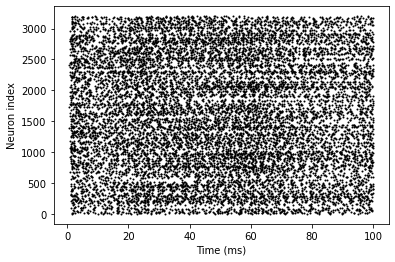

In [7]:
net = bp.Network(E_group, I_group, E2E, E2I, I2I, I2E)
net.run(100., report=True)
bp.visualize.raster_plot(net.ts, E_group.mon.spike, show=True)